<a href="https://colab.research.google.com/github/jackychia/AIforCE/blob/master/2912_%E7%B5%B1%E4%B8%80_model%E9%9A%8E%E6%AE%B5%E4%BA%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install seaborn
#!pip install git+https://github.com/tensorflow/docs

In [30]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
#%matplotlib inline

#import tensorflow as tf
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling
#from tensorflow import keras
#from tensorflow.keras import layers
#from scipy.ndimage import gaussian_filter1d
#from scipy.signal import medfilt
#print(tf.__version__) 

In [55]:
nfn = "https://raw.githubusercontent.com/jerryhuangyu/data_stock/master/2912.TW.csv"

In [ ]:
dataset = pd.read_csv(nfn, na_values = "0")
dataset

In [ ]:
dataset.isna().sum()

In [ ]:
#drop NaN
dataset = dataset.dropna()
dataset

In [ ]:
#add predict colume to "open_pre"
dataset['Close_pre'] = dataset['Close'].shift(-1)
close_pre = dataset.pop('Close_pre')
dataset

In [ ]:
#normalize
def norm(x):
  A = x.pop('Date')
  x = (x - dataset.min()) / (dataset.max() - dataset.min())
  x = x.transpose()
  x = x.append(A)
  x = x.transpose()
  return x
normed_dataset = norm(dataset)
normed_dataset

In [ ]:
#add "weekday","year","Month" colume from "Date"
normed_dataset['Date'] = pd.to_datetime(normed_dataset['Date'], format='%Y-%m-%d')
normed_dataset['weekday'] = normed_dataset['Date'].apply(lambda x: x.day)
normed_dataset['year'] = normed_dataset['Date'].apply(lambda x: x.year)
normed_dataset['Month'] = normed_dataset['Date'].apply(lambda x: x.month)
normed_dataset

In [ ]:
normed_dataset = normed_dataset.transpose()
normed_dataset = normed_dataset.append(close_pre)
normed_dataset = normed_dataset.transpose()
normed_dataset = normed_dataset.dropna()
normed_dataset

In [ ]:
dataset_stats = dataset.describe()
dataset_stats = dataset_stats.transpose()
dataset_stats

In [64]:
#train & test
test = normed_dataset[-60:]
test = test.reset_index()
train = normed_dataset[(normed_dataset['year']==2018)|(normed_dataset['year']==2019)|((normed_dataset['year']==2020)&(normed_dataset['Month']<=5))|((normed_dataset['year']==2020)&(normed_dataset['Month']==6)&(normed_dataset['weekday']<=21))]
train = train.reset_index()

In [ ]:
train

In [ ]:
sns.pairplot(train[["Close_pre","Open","High","Low","Close","Adj Close","Volume","weekday","Month"]], diag_kind="kde")

In [66]:
#Keep the feature u want
train.drop(['Date','year',"index",'Month','weekday','Adj Close'], axis=1, inplace=True)  #'Volume'
test.drop(['Date','year',"index",'Month','weekday','Adj Close',], axis=1, inplace=True)  #'Volume'

In [67]:
#Split features from labels
def train_windows(df, ref_day=5, predict_day=1):
    feature, solution = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        feature.append(np.array(df.iloc[i:i+ref_day,:-1]))
        solution.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["Close_pre"]))
    return np.array(feature), np.array(solution)

In [68]:
feature_train, solution_train = train_windows(train, 5, 1)
feature_test, solution_test = train_windows(test, 5, 1)

In [ ]:
solution_train

In [ ]:
solution_test

In [ ]:
feature_train

In [87]:
cell_layer1=256
cell_layer2=256
cell_layer3=256

def lstm_stock_model(shape):
  model = Sequential()
  model.add(LSTM(cell_layer1, activation='tanh', input_shape=(shape[1], shape[2]), return_sequences=True))
  model.add(BatchNormalization())
  model.add(LSTM(cell_layer2, activation='tanh', return_sequences=True))
  model.add(BatchNormalization())
  model.add(LSTM(cell_layer3))
#  model.add(BatchNormalization())
#  model.add(TimeDistributed(Dense(1)))
#  model.add(Flatten())

  model.add(Dense(5,activation='linear'))
  model.add(Dense(1,activation='linear'))

#  Optimizer = keras.optimizers.RMSprop(0.001)
#  Optimizer1 = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
#  Optimizer2 = keras.optimizers.Adam(learning_rate=0.001)

  model.compile(loss='mse', optimizer='adam', metrics=['mae','mse'])
  return model

In [ ]:
model = lstm_stock_model(feature_train.shape)
model.summary()

In [89]:
feature_train.shape

(591, 5, 5)

In [25]:
type(feature_train)

numpy.ndarray

In [26]:
#類型轉換才能輸入於fit()
#from keras import backend as K
#feature_train = K.cast_to_floatx(feature_train)
#solution_train = K.cast_to_floatx(solution_train)

In [27]:
type(feature_train)

numpy.ndarray

In [90]:
#fit model
EPOCHS = 2000
Batch_size = 32
#Batch_size=eval(input('The batch_size (default= 32):')or '32')
#EPOCHS=eval(input('Epochs (default 1000):')or '1000')

callback = EarlyStopping(monitor="mse", patience=30, verbose=1, mode="auto") #[tfdocs.modeling.EpochDots()]

history = model.fit(feature_train, solution_train, batch_size=Batch_size, epochs=EPOCHS, validation_split=0.1, verbose=1, callbacks=[callback],shuffle=True)
                    #[callback],shuffle=True)

Train on 531 samples, validate on 60 samples
Epoch 1/2000
531/531 [==============================] - 2s 5ms/step - loss: 83846.6696 - mae: 288.8036 - mse: 83846.6562 - val_loss: 87272.7135 - val_mae: 295.3026 - val_mse: 87272.7188
Epoch 2/2000
531/531 [==============================] - 1s 2ms/step - loss: 69457.9471 - mae: 262.8772 - mse: 69457.9531 - val_loss: 88730.1766 - val_mae: 297.7610 - val_mse: 88730.1719
Epoch 3/2000
531/531 [==============================] - 1s 2ms/step - loss: 60176.7044 - mae: 244.5743 - mse: 60176.7031 - val_loss: 89546.5969 - val_mae: 299.1306 - val_mse: 89546.6016
Epoch 4/2000
531/531 [==============================] - 1s 2ms/step - loss: 51446.5374 - mae: 226.0140 - mse: 51446.5352 - val_loss: 89674.7786 - val_mae: 299.3488 - val_mse: 89674.7812
Epoch 5/2000
531/531 [==============================] - 1s 2ms/step - loss: 43206.7253 - mae: 206.9802 - mse: 43206.7266 - val_loss: 89516.4557 - val_mae: 299.0893 - val_mse: 89516.4531
Epoch 6/2000
531/531 [===

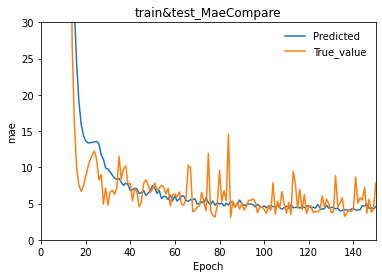

In [91]:
#mae
plt.plot(history.history['mae'],label='Predicted')     #train
plt.plot(history.history['val_mae'],label='True_value')    #test
plt.legend(frameon=False)
plt.xlim([0,170])
plt.ylim([0,30])

plt.title('train&test_MaeCompare')
plt.ylabel('mae')
plt.xlabel('Epoch')
print()

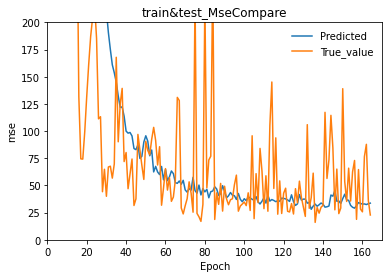

In [96]:
#mse
plt.plot(history.history['mse'],label='Predicted')
plt.plot(history.history['val_mse'],label='True_value')
plt.legend(frameon=False)
plt.xlim([0,170])
plt.ylim([0,200])

plt.title('train&test_MseCompare')
plt.ylabel('mse')
plt.xlabel('Epoch')
print()

In [93]:
#feature_test = K.cast_to_floatx(feature_test)
#solution_test = K.cast_to_floatx(solution_test)
solution_predict = model.predict(feature_test)

In [ ]:
solution_predict

In [ ]:
solution_test

In [94]:
#evaluate loss
loss = model.evaluate(feature_test,solution_test,verbose=0)
loss

[11.103781947383174, 2.590097427368164, 11.103782653808594]

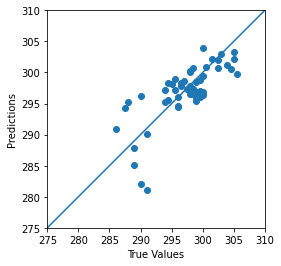

In [95]:
#ture & predict比較圖
a = plt.axes(aspect='equal')
plt.scatter(solution_test, solution_predict)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [275,310]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


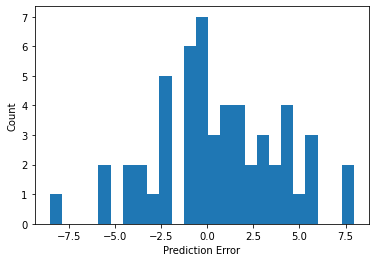

In [83]:
#errort長條圖
error = solution_predict - solution_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
